# Vision-Language Model

* 4bit quantised idefics-80b VLM
* 4bit quantised idefics-80b VLM with instruction-tuning

*use `idefics_colab` conda env*

In [1]:
import torch
from PIL import Image
from transformers import IdeficsForVisionText2Text, AutoProcessor, BitsAndBytesConfig
import torchvision.transforms as transforms
from sidemethods import load_richardson_data, logprobs_from_prompt
from tqdm import tqdm
import itertools
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns


_, richardson_data, richardson_normed = load_richardson_data()
action_words = richardson_normed.keys()

/mounts/Users/cisintern/pwicke/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mounts/work/pwicke/miniconda3/envs/idefics/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/mounts/Users/cisintern/pwicke/.local/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={

In [2]:
gpu = "all" # "all" or INT: 0,1,2,3
quantised = False

model_name = "idefics/idefics-80b"

In [3]:
# Check available gpu (gpustat -i)
if gpu == "all":
    device_map = "auto"
elif isinstance(gpu, int):
    device_map = {"" : gpu}


# checkpoint = "HuggingFaceM4/tiny-random-idefics"
local_path = "/mounts/data/corp/huggingface/"
checkpoint = local_path+model_name

# Here we skip some special modules that can't be quantized properly
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    llm_int8_skip_modules=["lm_head", "embed_tokens"],
)

# Idefics 80 non-instruct

In [4]:
processor = AutoProcessor.from_pretrained(checkpoint, use_auth_token=True)
quant_tag = ""
# Simply take-off the quantization_config arg if you want to load the original model
if quantised:
    model = IdeficsForVisionText2Text.from_pretrained(checkpoint,quantization_config=bnb_config, device_map=device_map) 
else:
    model = IdeficsForVisionText2Text.from_pretrained(checkpoint, device_map=device_map) 
    quant_tag = "-unquantised"


/mounts/work/pwicke/miniconda3/envs/idefics/lib/python3.10/site-packages/transformers/models/auto/processing_auto.py:203: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it]


In [6]:
def check_inference(model, processor, prompts, max_new_tokens=50):
    tokenizer = processor.tokenizer
    bad_words = ["<image>", "<fake_token_around_image>"]
    if len(bad_words) > 0:
        bad_words_ids = tokenizer(bad_words, add_special_tokens=False).input_ids

    eos_token = "</s>"
    eos_token_id = tokenizer.convert_tokens_to_ids(eos_token)

    if gpu == "all":
        inputs = processor(prompts, return_tensors="pt")
    else:
        inputs = processor(prompts, return_tensors="pt").to(device_map[""])
        
    generated_ids = model.generate(**inputs, 
                                   eos_token_id=[eos_token_id], 
                                   bad_words_ids=bad_words_ids, 
                                   max_new_tokens=max_new_tokens, 
                                   early_stopping=False,
                                   num_beams=1, 
                                   )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

def check_logprobs(model, processor, prompts, max_new_tokens=50):
    tokenizer = processor.tokenizer
    bad_words = ["<image>", "<fake_token_around_image>"]
    if len(bad_words) > 0:
        bad_words_ids = tokenizer(bad_words, add_special_tokens=False).input_ids

    eos_token = "</s>"
    eos_token_id = tokenizer.convert_tokens_to_ids(eos_token)

    if gpu == "all":
        inputs = processor(prompts, return_tensors="pt")
    else:
        inputs = processor(prompts, return_tensors="pt").to(device_map[""])

    input_ids = inputs["input_ids"]
    output = model(input_ids=input_ids)
 
    shift_labels = input_ids[..., 1:].contiguous()
    shift_logits = output.logits[..., :-1, :].contiguous()
    log_probs = []
    log_probs.append((tokenizer.decode(input_ids[0].tolist()[0]), None))
    for idx, (label_id, logit) in enumerate(zip(shift_labels[0].tolist(), shift_logits[0])):
        logit = logit.type(torch.FloatTensor) # device_map="auto" fpr model initialization
        logprob = F.log_softmax(logit, dim=0)[label_id].item()
        log_probs.append((tokenizer.decode(label_id), float(logprob)))
    return log_probs
  

## Testing Prompts for Experiment

In [6]:
images = []
for i in range(1,5):
    img_path = "../../data/direction0"+str(i)+".png"
    images.append(Image.open(img_path).convert("RGB"))

prompts = [
    # "Instruction: provide an answer to the question. Use the image to answer.\n",
    "Image A:",
    images[0],
    "Image B:",
    images[1],
    "Image C:",
    images[2],
    "Image D:",
    images[3],
    "Question: Which one of the images (A-D) describes the event 'arrow down' best? Answer: Image "
]
print(check_inference(model, processor, prompts, max_new_tokens=2))


Image A: Image B: Image C: Image D: Question: Which one of the images (A-D) describes the event 'arrow down' best? Answer: Image B.


In [14]:
images = []
for i in range(1,5):
    img_path = "../../data/direction0"+str(i)+".png"
    images.append(Image.open(img_path).convert("RGB"))

prompts = [
    # "Instruction: provide an answer to the question. Use the image to answer.\n",
    "Image A:",
    images[0],
    "Image B:",
    images[1],
    "Image C:",
    images[2],
    "Image D:",
    images[3],
    "Question: Give a one sentence description for each image. The description should focus on the differences. Answer:"
]
check_inference(model, processor, prompts, max_new_tokens=60)


'Image A: Image B: Image C: Image D: Question: Give a one sentence description for each image. The description should focus on the differences. Answer:\n\nImage A: The object is moving to the right.\n\nImage B: The object is moving to the left.\n\nImage C: The object is moving up and down.\n\nImage D: The object is moving up and down.\n\nQuestion: What is the difference'

## Prompt Search

In [54]:
images = []
for i in range(1,5):
    img_path = "../../data/direction0"+str(i)+".png"
    images.append(Image.open(img_path).convert("RGB"))

prompts = [
    # "Instruction: provide an answer to the question. Use the image to answer.\n",
    "Image A:",
    images[0],
    "Image B:",
    images[1],
    "Image C:",
    images[2],
    "Image D:",
    images[3],
    "Question: Which one of the images describes the event 'fled' best? Do not provide a number, only give the image code. Answer: Image "
]
check_inference(model, processor, prompts, max_new_tokens=5)


"Image A: Image B: Image C: Image D: Question: Which one of the images describes the event 'fled' best? Do not provide a number, only give the image code. Answer: Image A\n\nQuestion:"

# Run experiment

 Initial experiments show that encoding with A, B, C, D was heavily favouring the selection of image A no matter the order or image. This suggests that the letter A has some primary features due to its alphabetical order. This bias can potentially be mitigated by selecting a set of codes that are designed to have minimal suggestion of acronyms or patterns, providing a more neutral set of labels for your image classification task

In [7]:
model_choices = dict()
options = {0:'WJZX', 1:'YGPK', 2:'FQHL', 3:'VMBR'} # up, down, left, right

images = []
for i in range(1,5):
    img_path = "../../data/direction0"+str(i)+".png"
    images.append(Image.open(img_path).convert("RGB"))

def find_earliest_string(strings, target_string):
    found_strings = [s for s in strings if s in target_string]
    return min(found_strings, key=target_string.find, default=None)

with open("results/VISUAL_"+model_name.split("/")[1]+quant_tag+"_responses.txt", "w") as f_out:
    for action_word in tqdm(action_words):

        if action_word == 0:
            continue

        for choice_list in list(itertools.permutations(options)):

            ### PROMPTS DEFINED HERE
            ending = "Answer: For '"+action_word+"' it is Image "
            prompts = [
                        f"\nImage {options[choice_list[0]]}:",
                        images[choice_list[0]],
                        f"\nImage {options[choice_list[1]]}:",
                        images[choice_list[1]],
                        f"\nImage {options[choice_list[2]]}:",
                        images[choice_list[2]],
                        f"\nImage {options[choice_list[3]]}:",
                        images[choice_list[3]],
                        "\nQuestion: Which is the best image to describe the event '"+action_word+"'?\n"+ending
                    ]

            new_token_num = 4
            generated_answer = check_inference(model, processor, prompts, max_new_tokens=new_token_num) 
            generated_answer = generated_answer.split(ending)[1]


            counted = False
            if action_word not in model_choices.keys():
                model_choices[action_word] = [0,0,0,0]

            targets = list(options.values())
            finding = find_earliest_string(targets, generated_answer)
            if finding:
                model_choices[action_word][targets.index(finding)]+=1
                counted = True

            if sum(model_choices[action_word]) > 24:
                print("Too many arrows in response.")
                
            promptstring = prompts[0]+prompts[2]+prompts[4]+prompts[6]
            promptstring = promptstring.replace("\n","").replace("Image ","").replace(":",",")
            f_out.write(action_word+"\t"+promptstring+"\t"+generated_answer.replace("\n","")+"\n")

print(model_choices)
# 30min on llama 70b
# 30min on llama 70b chat
# 5min on llama 13b
# 5min on llama 13b chat

100%|██████████| 30/30 [20:41:19<00:00, 2482.64s/it]   

{'fled': [2, 6, 14, 2], 'pointed at': [5, 6, 7, 6], 'pulled': [6, 6, 7, 5], 'pushed': [5, 6, 8, 5], 'walked': [5, 6, 8, 5], 'hunted': [6, 6, 7, 5], 'impacted': [6, 6, 6, 6], 'perched': [6, 6, 8, 4], 'showed': [5, 6, 7, 6], 'smashed': [5, 6, 8, 5], 'bombed': [5, 6, 7, 6], 'flew': [1, 5, 17, 1], 'floated': [2, 6, 14, 2], 'lifted': [6, 6, 7, 5], 'sank': [5, 6, 9, 4], 'argued with': [5, 6, 7, 6], 'gave to': [3, 6, 9, 6], 'offended': [5, 6, 7, 6], 'rushed': [6, 6, 6, 6], 'warned': [5, 6, 7, 6], 'owned': [5, 6, 7, 6], 'regretted': [5, 6, 8, 5], 'rested': [6, 6, 6, 6], 'tempted': [6, 6, 6, 6], 'wanted': [6, 6, 6, 6], 'hoped': [3, 8, 9, 4], 'increased': [6, 6, 7, 5], 'obeyed': [6, 6, 6, 6], 'respected': [6, 6, 6, 6], 'succeeded': [5, 6, 8, 5]}


### Storing Experimental Results

In [12]:
to_store = input("Should the result for "+model_name+" be stored? (y/n):")

if to_store == "y":

    with open("results/VISUAL_"+model_name.split("/")[1]+quant_tag+"_selections.txt", "w") as f_out:
        f_out.write("Action\tUP\tDOWN\tLEFT\tRIGHT\n")
        for k,v in model_choices.items():
            f_out.write(k+"\t"+"\t".join([str(x) for x in v])+"\n")
    

### Loading Experimental Results

In [13]:
model_choices = dict()
with open("results/VISUAL_"+model_name.split("/")[1]+quant_tag+"_selections.txt", "r") as f_in:
    lines = f_in.readlines()

for idx,line in enumerate(lines):
    if idx == 0:
        continue
    parts = line.split("\t")
    parts[-1].replace("\n","")
    model_choices[parts[0]] = [int(x) for x in parts[1:]]

### Cosine similarity (within and out of constructs)

In [14]:
similarity_scores_items = {}
similarity_scores_constructs = {'Horizontal':0, 'Neutral':0, 'Vertical':0, 'Horizon.':0, 'Neutr.':0, 'Vertic.':0}

for idx, key in enumerate(richardson_data):

    # for each item
    vec1 = np.array(richardson_data[key])
    vec2 = np.array(model_choices[key])
    similarity = cosine_similarity([vec1], [vec2])[0][0]
    similarity_scores_items[key] = similarity

print(similarity_scores_items)

count = 0
for i in range(0,len(similarity_scores_items),5): # every 5th item is a different construct 
    current_constr = list(similarity_scores_constructs.keys())[count]
    constr_sum = round((sum(list(similarity_scores_items.values())[i:i+4])/5),4)
    similarity_scores_constructs[current_constr] = constr_sum
    count+=1

print(similarity_scores_constructs)

{'fled': 0.9384741489192909, 'pointed at': 0.5477792756653623, 'pulled': 0.7120077117194058, 'pushed': 0.46859907352518615, 'walked': 0.687962232869797, 'hunted': 0.6143701946911914, 'impacted': 0.7701847485056645, 'perched': 0.6311770161648822, 'showed': 0.7152321317951968, 'smashed': 0.6417982132844114, 'bombed': 0.5665973834236698, 'flew': 0.48371983730272444, 'floated': 0.5093953542696252, 'lifted': 0.5662240795240902, 'sank': 0.6198747722934961, 'argued with': 0.7542409364370322, 'gave to': 0.5554779875192438, 'offended': 0.9468635498469552, 'rushed': 0.8066006366071711, 'warned': 0.7451641818847325, 'owned': 0.8140766700633465, 'regretted': 0.9833168789803083, 'rested': 0.879957177397956, 'tempted': 0.887476711252644, 'wanted': 0.7649677646872837, 'hoped': 0.5983303084861873, 'increased': 0.657586625187, 'obeyed': 0.7228516532036796, 'respected': 0.7960350485772214, 'succeeded': 0.821851411353028}
{'Horizontal': 0.5334, 'Neutral': 0.5462, 'Vertical': 0.4252, 'Horizon.': 0.6126, '

/tmp/ipykernel_1167132/1341278945.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(data.values()), y=list(data.keys()), palette=custom_palette)


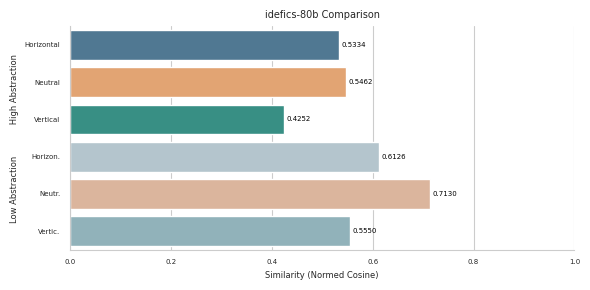

In [15]:
data = similarity_scores_constructs
custom_palette = ['#457b9d', '#f4a261', '#2a9d8f', '#b0c6d1', '#e5b293', '#8ab6c1']

plt.figure(figsize=(6, 3))
sns.set_style("whitegrid")
sns.barplot(x=list(data.values()), y=list(data.keys()), palette=custom_palette)

plt.xlabel('Similarity (Normed Cosine)', fontsize=6)
plt.ylabel('Low Abstraction            High Abstraction', fontsize=6)
plt.title(model_name.split("/")[1]+' Comparison', fontsize=7)

for i, value in enumerate(data.values()):
    plt.text(value + 0.005, i, f'{value:.4f}', va='center', fontsize=5, color='black')

plt.xlim(0, 1)
sns.despine()
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.tight_layout()
plt.savefig("results/VISUAL_"+model_name.split("/")[1]+quant_tag+"_CosSim.png")
plt.show()


In [16]:
# Check if file TEXT_average_similarities.txt exists, else create it
try:
    with open("results/VISUAL_average_similarities.txt", "r") as f_in:
        lines = f_in.readlines()
except FileNotFoundError:
    with open("results/VISUAL_average_similarities.txt", "w") as f_out:
        f_out.write("Model\tAverage Similarity\n")
        f_out.close()


average_sim = sum(similarity_scores_constructs.values())/len(similarity_scores_constructs.values())
print("Average similarity between human choice and model choices is: ", round(average_sim,5))

# Write the average similarity to a text file with the name of the model
# Model name is the first part of the line in the file
# Check if entry for current model already exists, else append

with open("results/VISUAL_average_similarities.txt", "r") as f_in:
    lines = f_in.readlines()

with open("results/VISUAL_average_similarities.txt", "w") as f_out:
    for line in lines:
        if line.startswith(model_name.split("/")[1]+"-unquantised"):
            line = model_name.split("/")[1]+quant_tag+"\t"+str(average_sim)+"\n"
        f_out.write(line)
        # append average similarity if model not yet in file
    if not any(model_name.split("/")[1]+"-unquantised" in line for line in lines):
        f_out.write(model_name.split("/")[1]+quant_tag+"\t"+str(average_sim)+"\n")

Average similarity between human choice and model choices is:  0.56423


In [17]:
print("Human % distrib.:", richardson_data)
print("Model distrib.:", model_choices)
model_percentages = {k:[round(100*(x/24),5) for x in entries] for k, entries in model_choices.items()}
print("Model % distrib.:", model_percentages)

Human % distrib.: {'fled': [7.2, 4.2, 80.8, 7.8], 'pointed at': [7.2, 3.6, 0.0, 89.2], 'pulled': [6.0, 5.4, 75.4, 13.2], 'pushed': [7.2, 3.6, 1.2, 88.0], 'walked': [9.0, 3.6, 24.0, 62.9], 'hunted': [9.6, 20.4, 1.8, 68.3], 'impacted': [7.2, 37.1, 3.0, 52.7], 'perched': [12.0, 76.0, 6.6, 5.4], 'showed': [15.0, 9.0, 10.2, 65.9], 'smashed': [3.6, 66.5, 1.2, 28.7], 'bombed': [4.8, 86.8, 1.8, 6.6], 'flew': [37.7, 44.3, 15.0, 3.0], 'floated': [32.9, 56.3, 7.8, 3.0], 'lifted': [87.4, 9.6, 2.4, 0.6], 'sank': [22.2, 71.9, 4.2, 1.8], 'argued with': [11.4, 13.8, 12.6, 62.3], 'gave to': [8.4, 9.6, 1.2, 80.8], 'offended': [9.0, 31.7, 24.6, 34.7], 'rushed': [10.2, 10.8, 23.4, 55.1], 'warned': [10.8, 22.2, 6.0, 61.1], 'owned': [5.4, 55.7, 18.6, 20.4], 'regretted': [19.8, 24.0, 41.3, 15.0], 'rested': [14.4, 36.5, 40.1, 9.0], 'tempted': [16.8, 11.4, 45.5, 26.3], 'wanted': [15.6, 7.8, 15.6, 61.1], 'hoped': [45.5, 15.6, 7.2, 31.7], 'increased': [73.7, 7.2, 9.6, 9.0], 'obeyed': [22.8, 4.2, 64.7, 8.4], 'res

## Spearman R

In [18]:
# Assuming you have two dictionaries: model_percentages and richardson_data
concepts = ["C:◯↑▢", 'D:◯↓▢', 'B:◯←▢ ', 'A:◯→▢']
spearmanr_values = {}

for concept in concepts:
    model_values = [model_percentages[key][concepts.index(concept)] for key in model_percentages]
    richardson_values = [richardson_data[key][concepts.index(concept)] for key in richardson_data]

    spearmanr_result = spearmanr(model_values, richardson_values)
    spearmanr_values[concept] = spearmanr_result.correlation, spearmanr_result.pvalue

In [22]:
# Check if file TEXT_spearmanr.txt exists, else create it

try:
    with open("results/VISUAL_spearmanr.txt", "r") as f_in:
        lines = f_in.readlines()
except FileNotFoundError:
    with open("results/VISUAL_spearmanr.txt", "w") as f_out:
        f_out.write("Model\tC\tD\tB\tA\n")
        f_out.close()

with open("results/VISUAL_spearmanr.txt", "r") as f_in:
    lines = f_in.readlines()

with open("results/VISUAL_spearmanr.txt", "w") as f_out:
    for line in lines:
        if line.startswith(model_name.split("/")[1]+quant_tag):
            line = model_name.split("/")[1]+quant_tag+"\t"+'\t'.join([','.join(map(str, tup)) for tup in spearmanr_values.values()])+"\n"
        f_out.write(line)
        # append average similarity if model not yet in file
    if not any(model_name.split("/")[1]+quant_tag in line for line in lines):
        f_out.write(model_name.split("/")[1]+quant_tag+"\t"+'\t'.join([','.join(map(str, tup)) for tup in spearmanr_values.values()])+"\n")

spearmanr_values


{'C:◯↑▢': (0.12358033578481831, 0.5152937253241124),
 'D:◯↓▢': (-0.11940298507462685, 0.5297010403765472),
 'B:◯←▢ ': (-0.22900887646866153, 0.22349302011315486),
 'A:◯→▢': (0.49189457840353806, 0.00576449721261497)}

## Visualization of Choice Distribution

/tmp/ipykernel_1167132/3454836461.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


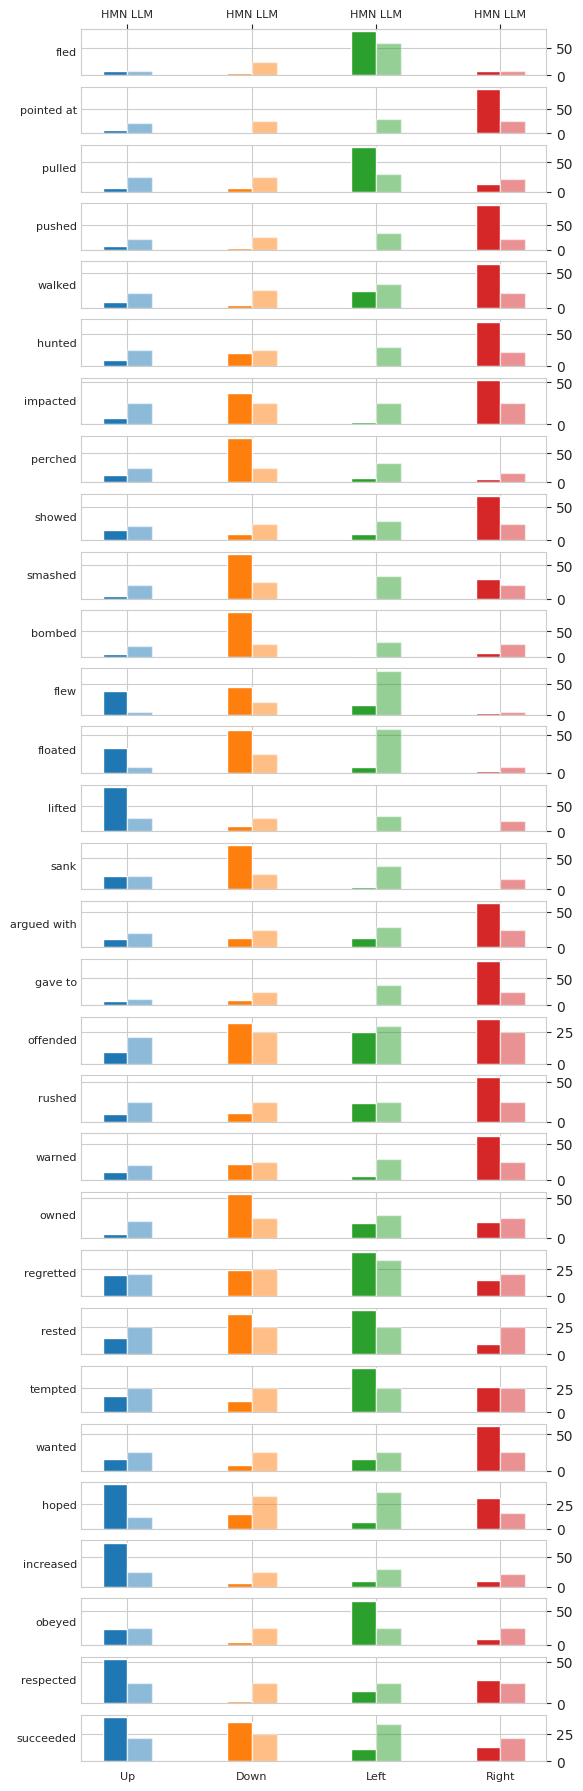

In [23]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data_old = richardson_data
data_new = model_percentages

action_names = list(data_old.keys())
num_actions = len(action_names)
num_subplots = len(data_old[action_names[0]])

fig_width = 6
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Create a GridSpec layout
fig = plt.figure(figsize=(fig_width, .75*num_actions))  # Adjust the height factor as needed
gs = gridspec.GridSpec(num_actions, 1, figure=fig, hspace=0.25)  # You can adjust hspace as needed

bar_width_old = 0.2  # Width of the old bars
bar_width_new = bar_width_old /2  # Width of the new bars

for i, action in enumerate(action_names):

    values_old = data_old[action]
    values_new = data_new[action]
    
    positions_old = np.arange(num_subplots) 
    positions_new = positions_old + bar_width_old  # Shift the new bars to the right
    
    bottom_old = np.zeros(num_subplots)
    bottom_new = np.zeros(num_subplots)
    
    ax = fig.add_subplot(gs[i, 0])
    
    for j, (value_old, value_new) in enumerate(zip(values_old, values_new)):
        color_A = colors[j]

        ax.bar(positions_old[j]-.1, value_old, bottom=bottom_old[j], width=bar_width_old, color=color_A)
        new_bar_x = positions_new[j] #+ bar_width_new / 2  # Middle of the new bar
        ax.bar(positions_new[j]-.1, value_new, bottom=bottom_new[j], width=bar_width_new*2, color=color_A, alpha=0.5)
        
        bottom_old[j] += value_old
        bottom_new[j] += value_new
        

    ax.set_xticks(positions_old)
    ax.set_xticklabels([])
    
    if i == num_actions - 1:
        ax.set_xticklabels(["Up", 'Down', 'Left', 'Right'], fontsize=8)  # Adjust fontsize as needed
    if i == 0 :
        ax.set_xticklabels(["HMN LLM", 'HMN LLM', 'HMN LLM', 'HMN LLM'], fontsize=8)  # Adjust fontsize as needed
        ax.xaxis.set_ticks_position('top')
        ax.xaxis.set_label_position('top')
        
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    
    ax.text(-.01, 0.5, action, transform=ax.transAxes, rotation=0, va='center', ha='right', fontsize=8)

plt.tight_layout()
plt.savefig("results/VISUAL_"+model_name.split("/")[1]+quant_tag+"_Choices.png")
plt.show()


# Instruct Model

In [ ]:
# stored in cache, hence
checkpoint = "HuggingFaceM4/idefics-80b-instruct"
model_name = "idefics/idefics-80b-instruct"

processor = AutoProcessor.from_pretrained(checkpoint, use_auth_token=True)
model = IdeficsForVisionText2Text.from_pretrained(checkpoint, quantization_config=bnb_config ,device_map=device_map,cache_dir="/mounts/data/corp/huggingface/hub/")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 17/17 [05:49<00:00, 20.54s/it]


In [4]:
# stored in cache, but not in quantized form
checkpoint = "HuggingFaceM4/idefics-80b-instruct"
model_name = "idefics/idefics-80b-instruct"

processor = AutoProcessor.from_pretrained(checkpoint, use_auth_token=True)
model = IdeficsForVisionText2Text.from_pretrained(checkpoint ,device_map="auto",cache_dir="/mounts/data/corp/huggingface/hub/")

/mounts/work/pwicke/miniconda3/envs/idefics/lib/python3.10/site-packages/transformers/models/auto/processing_auto.py:203: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 17/17 [05:07<00:00, 18.11s/it]


# Run experiment

 Initial experiments show that encoding with A, B, C, D was heavily favouring the selection of image A no matter the order or image. This suggests that the letter A has some primary features due to its alphabetical order. This bias can potentially be mitigated by selecting a set of codes that are designed to have minimal suggestion of acronyms or patterns, providing a more neutral set of labels for your image classification task

In [ ]:
prompts = [
            "Instruction: You are given four images and are supposed to select one to answer a question.\n",
            f"Image {options[choice_list[0]]}:",
            images[choice_list[0]],
            f"Image {options[choice_list[1]]}:",
            images[choice_list[1]],
            f"Image {options[choice_list[2]]}:",
            images[choice_list[2]],
            f"Image {options[choice_list[3]]}:",
            images[choice_list[3]],
            "Question: Which image best describes the event '"+action_word+"'? Answer: "
        ]

# CURRENT TODO
* make backup of **non** instruct results
* after backup: create new cells at bottom to run **non** instruct with prompt without instructions, but otherwise same prompt

In [8]:
model_choices = dict()
options = {0:'WJZX', 1:'YGPK', 2:'XQHL', 3:'VMBR'} # up, down, left, right

images = []
for i in range(1,5):
    img_path = "../../data/direction0"+str(i)+".png"
    images.append(Image.open(img_path).convert("RGB"))

def find_earliest_string(strings, target_string):
    found_strings = [s for s in strings if s in target_string]
    return min(found_strings, key=target_string.find, default=None)

with open("results/VISUAL_"+model_name.split("/")[1]+"-unquantised_responses.txt", "w") as f_out:
    for action_word in tqdm(action_words):

        if action_word == 0:
            continue

        for choice_list in list(itertools.permutations(options)):

            ### PROMPTS DEFINED HERE
            ending = "Answer: For '"+action_word+"' it is Image "
            prompts = [
                        "Instruction: You are shown four images. Select one of the four images to answer the question.\n",
                        f"\nImage {options[choice_list[0]]}:",
                        images[choice_list[0]],
                        f"\nImage {options[choice_list[1]]}:",
                        images[choice_list[1]],
                        f"\nImage {options[choice_list[2]]}:",
                        images[choice_list[2]],
                        f"\nImage {options[choice_list[3]]}:",
                        images[choice_list[3]],
                        "\nQuestion: Which is the best image to describe the event '"+action_word+"'?\n"+ending
                    ]

            new_token_num = 4
            generated_answer = check_inference(model, processor, prompts, max_new_tokens=new_token_num) 
            #print("Full answer:", generated_answer)
            # create a string from the list prompts that only contains the strings
            generated_answer = generated_answer.split(ending)[1]
            #print("Retrieved answer:", generated_answer)
            #print("-------")

            counted = False
            if action_word not in model_choices.keys():
                model_choices[action_word] = [0,0,0,0]

            targets = list(options.values())
            finding = find_earliest_string(targets, generated_answer)
            if finding:
                model_choices[action_word][targets.index(finding)]+=1
                counted = True

            if sum(model_choices[action_word]) > 24:
                print("Too many arrows in response.")
                
            promptstring = prompts[1]+prompts[3]+prompts[5]+prompts[7]
            promptstring = promptstring.replace("\n","").replace("Image ","").replace(":",",")
            f_out.write(action_word+"\t"+promptstring+"\t"+generated_answer.replace("\n","")+"\n")

print(model_choices)


100%|██████████| 30/30 [19:33:18<00:00, 2346.62s/it]  

{'fled': [0, 3, 15, 6], 'pointed at': [3, 6, 6, 9], 'pulled': [2, 7, 9, 6], 'pushed': [2, 9, 9, 4], 'walked': [2, 5, 8, 9], 'hunted': [0, 3, 15, 6], 'impacted': [0, 4, 14, 6], 'perched': [1, 8, 8, 7], 'showed': [2, 5, 10, 7], 'smashed': [0, 2, 16, 6], 'bombed': [0, 3, 16, 5], 'flew': [2, 6, 10, 6], 'floated': [2, 7, 9, 6], 'lifted': [2, 10, 9, 3], 'sank': [0, 4, 15, 5], 'argued with': [2, 2, 12, 8], 'gave to': [2, 4, 12, 6], 'offended': [1, 3, 11, 9], 'rushed': [0, 3, 16, 5], 'warned': [2, 2, 13, 7], 'owned': [2, 3, 13, 6], 'regretted': [1, 1, 13, 9], 'rested': [1, 4, 9, 10], 'tempted': [0, 2, 15, 7], 'wanted': [2, 1, 11, 10], 'hoped': [2, 3, 9, 10], 'increased': [0, 3, 16, 5], 'obeyed': [1, 2, 13, 8], 'respected': [2, 2, 12, 8], 'succeeded': [1, 3, 14, 6]}


### Storing Experimental Results

In [9]:
to_store = input("Should the result for "+model_name+" be stored? (y/n):")

if to_store == "y":

    with open("results/VISUAL_"+model_name.split("/")[1]+"_selections.txt", "w") as f_out:
        f_out.write("Action\tUP\tDOWN\tLEFT\tRIGHT\n")
        for k,v in model_choices.items():
            f_out.write(k+"\t"+"\t".join([str(x) for x in v])+"\n")
    

### Loading Experimental Results

In [10]:
model_choices = dict()
with open("results/VISUAL_"+model_name.split("/")[1]+"_selections.txt", "r") as f_in:
    lines = f_in.readlines()

for idx,line in enumerate(lines):
    if idx == 0:
        continue
    parts = line.split("\t")
    parts[-1].replace("\n","")
    model_choices[parts[0]] = [int(x) for x in parts[1:]]

### Cosine similarity (within and out of constructs)

In [11]:
similarity_scores_items = {}
similarity_scores_constructs = {'Horizontal':0, 'Neutral':0, 'Vertical':0, 'Horizon.':0, 'Neutr.':0, 'Vertic.':0}

for idx, key in enumerate(richardson_data):

    # for each item
    vec1 = np.array(richardson_data[key])
    vec2 = np.array(model_choices[key])
    similarity = cosine_similarity([vec1], [vec2])[0][0]
    similarity_scores_items[key] = similarity

print(similarity_scores_items)

count = 0
for i in range(0,len(similarity_scores_items),5): # every 5th item is a different construct 
    current_constr = list(similarity_scores_constructs.keys())[count]
    constr_sum = round((sum(list(similarity_scores_items.values())[i:i+4])/5),4)
    similarity_scores_constructs[current_constr] = constr_sum
    count+=1

print(similarity_scores_constructs)

{'fled': 0.9481938233741284, 'pointed at': 0.7421414460051703, 'pulled': 0.804718153369605, 'pushed': 0.34355167020481225, 'walked': 0.8850756451724928, 'hunted': 0.4212417894032917, 'impacted': 0.4955234993868186, 'perched': 0.6880233995487572, 'showed': 0.6939653543312505, 'smashed': 0.2599729020887412, 'bombed': 0.21697175332727206, 'flew': 0.6381326771443019, 'floated': 0.6394343677969935, 'lifted': 0.24013440210549858, 'sank': 0.29246737541901746, 'argued with': 0.7212826887629654, 'gave to': 0.4791861975321609, 'offended': 0.8769079789881797, 'rushed': 0.6495937648869862, 'warned': 0.5747008943279488, 'owned': 0.5883909891037038, 'regretted': 0.8373882529311841, 'rested': 0.7645631007113116, 'tempted': 0.9468074971011986, 'wanted': 0.8353053515588401, 'hoped': 0.6425862377969223, 'increased': 0.17192424513667318, 'obeyed': 0.8795355596901578, 'respected': 0.5591821633957537, 'succeeded': 0.43060108550078924}
{'Horizontal': 0.5677, 'Neutral': 0.4598, 'Vertical': 0.3469, 'Horizon.'

/tmp/ipykernel_2858312/2278721997.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(data.values()), y=list(data.keys()), palette=custom_palette)


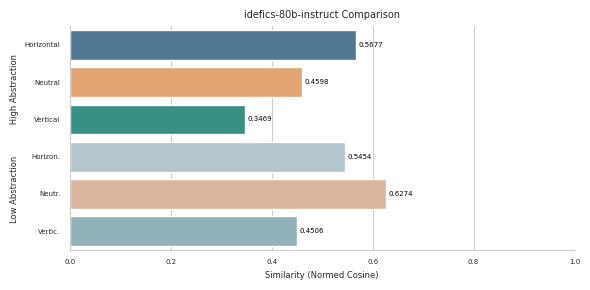

In [12]:
data = similarity_scores_constructs
custom_palette = ['#457b9d', '#f4a261', '#2a9d8f', '#b0c6d1', '#e5b293', '#8ab6c1']

plt.figure(figsize=(6, 3))
sns.set_style("whitegrid")
sns.barplot(x=list(data.values()), y=list(data.keys()), palette=custom_palette)

plt.xlabel('Similarity (Normed Cosine)', fontsize=6)
plt.ylabel('Low Abstraction            High Abstraction', fontsize=6)
plt.title(model_name.split("/")[1]+' Comparison', fontsize=7)

for i, value in enumerate(data.values()):
    plt.text(value + 0.005, i, f'{value:.4f}', va='center', fontsize=5, color='black')

plt.xlim(0, 1)
sns.despine()
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.tight_layout()
plt.savefig("results/VISUAL_"+model_name.split("/")[1]+"_CosSim.png")
plt.show()


In [13]:
# Check if file TEXT_average_similarities.txt exists, else create it
try:
    with open("results/VISUAL_average_similarities.txt", "r") as f_in:
        lines = f_in.readlines()
except FileNotFoundError:
    with open("results/VISUAL_average_similarities.txt", "w") as f_out:
        f_out.write("Model\tAverage Similarity\n")
        f_out.close()


average_sim = sum(similarity_scores_constructs.values())/len(similarity_scores_constructs.values())
print("Average similarity between human choice and model choices is: ", round(average_sim,5))

# Write the average similarity to a text file with the name of the model
# Model name is the first part of the line in the file
# Check if entry for current model already exists, else append

with open("results/VISUAL_average_similarities.txt", "r") as f_in:
    lines = f_in.readlines()

with open("results/VISUAL_average_similarities.txt", "w") as f_out:
    for line in lines:
        if line.startswith(model_name.split("/")[1]):
            line = model_name.split("/")[1]+"\t"+str(average_sim)+"\n"
        f_out.write(line)
        # append average similarity if model not yet in file
    if not any(model_name.split("/")[1] in line for line in lines):
        f_out.write(model_name.split("/")[1]+"\t"+str(average_sim)+"\n")

Average similarity between human choice and model choices is:  0.49963


In [14]:
print("Human % distrib.:", richardson_data)
print("Model distrib.:", model_choices)
model_percentages = {k:[round(100*(x/24),5) for x in entries] for k, entries in model_choices.items()}
print("Model % distrib.:", model_percentages)

Human % distrib.: {'fled': [7.2, 4.2, 80.8, 7.8], 'pointed at': [7.2, 3.6, 0.0, 89.2], 'pulled': [6.0, 5.4, 75.4, 13.2], 'pushed': [7.2, 3.6, 1.2, 88.0], 'walked': [9.0, 3.6, 24.0, 62.9], 'hunted': [9.6, 20.4, 1.8, 68.3], 'impacted': [7.2, 37.1, 3.0, 52.7], 'perched': [12.0, 76.0, 6.6, 5.4], 'showed': [15.0, 9.0, 10.2, 65.9], 'smashed': [3.6, 66.5, 1.2, 28.7], 'bombed': [4.8, 86.8, 1.8, 6.6], 'flew': [37.7, 44.3, 15.0, 3.0], 'floated': [32.9, 56.3, 7.8, 3.0], 'lifted': [87.4, 9.6, 2.4, 0.6], 'sank': [22.2, 71.9, 4.2, 1.8], 'argued with': [11.4, 13.8, 12.6, 62.3], 'gave to': [8.4, 9.6, 1.2, 80.8], 'offended': [9.0, 31.7, 24.6, 34.7], 'rushed': [10.2, 10.8, 23.4, 55.1], 'warned': [10.8, 22.2, 6.0, 61.1], 'owned': [5.4, 55.7, 18.6, 20.4], 'regretted': [19.8, 24.0, 41.3, 15.0], 'rested': [14.4, 36.5, 40.1, 9.0], 'tempted': [16.8, 11.4, 45.5, 26.3], 'wanted': [15.6, 7.8, 15.6, 61.1], 'hoped': [45.5, 15.6, 7.2, 31.7], 'increased': [73.7, 7.2, 9.6, 9.0], 'obeyed': [22.8, 4.2, 64.7, 8.4], 'res

## Spearman R

In [15]:
# Assuming you have two dictionaries: model_percentages and richardson_data
concepts = ["C:◯↑▢", 'D:◯↓▢', 'B:◯←▢ ', 'A:◯→▢']
spearmanr_values = {}

for concept in concepts:
    model_values = [model_percentages[key][concepts.index(concept)] for key in model_percentages]
    richardson_values = [richardson_data[key][concepts.index(concept)] for key in richardson_data]

    spearmanr_result = spearmanr(model_values, richardson_values)
    spearmanr_values[concept] = spearmanr_result.correlation, spearmanr_result.pvalue

In [16]:
# Check if file TEXT_spearmanr.txt exists, else create it

try:
    with open("results/VISUAL_spearmanr.txt", "r") as f_in:
        lines = f_in.readlines()
except FileNotFoundError:
    with open("results/VISUAL_spearmanr.txt", "w") as f_out:
        f_out.write("Model\tC\tD\tB\tA\n")
        f_out.close()

with open("results/VISUAL_spearmanr.txt", "r") as f_in:
    lines = f_in.readlines()

with open("results/VISUAL_spearmanr.txt", "w") as f_out:
    for line in lines:
        if line.startswith(model_name.split("/")[1]):
            line = model_name.split("/")[1]+"\t"+'\t'.join([','.join(map(str, tup)) for tup in spearmanr_values.values()])+"\n"
        f_out.write(line)
        # append average similarity if model not yet in file
    if not any(model_name.split("/")[1] in line for line in lines):
        f_out.write(model_name.split("/")[1]+"\t"+'\t'.join([','.join(map(str, tup)) for tup in spearmanr_values.values()])+"\n")

spearmanr_values


{'C:◯↑▢': (0.10002951573384145, 0.5989396449237185),
 'D:◯↓▢': (0.008623141971024258, 0.9639281942478033),
 'B:◯←▢ ': (0.019075959252937414, 0.9203025933201691),
 'A:◯→▢': (0.30353878439964543, 0.10296604745978796)}

## Visualization of Choice Distribution

/tmp/ipykernel_2858312/2284916719.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


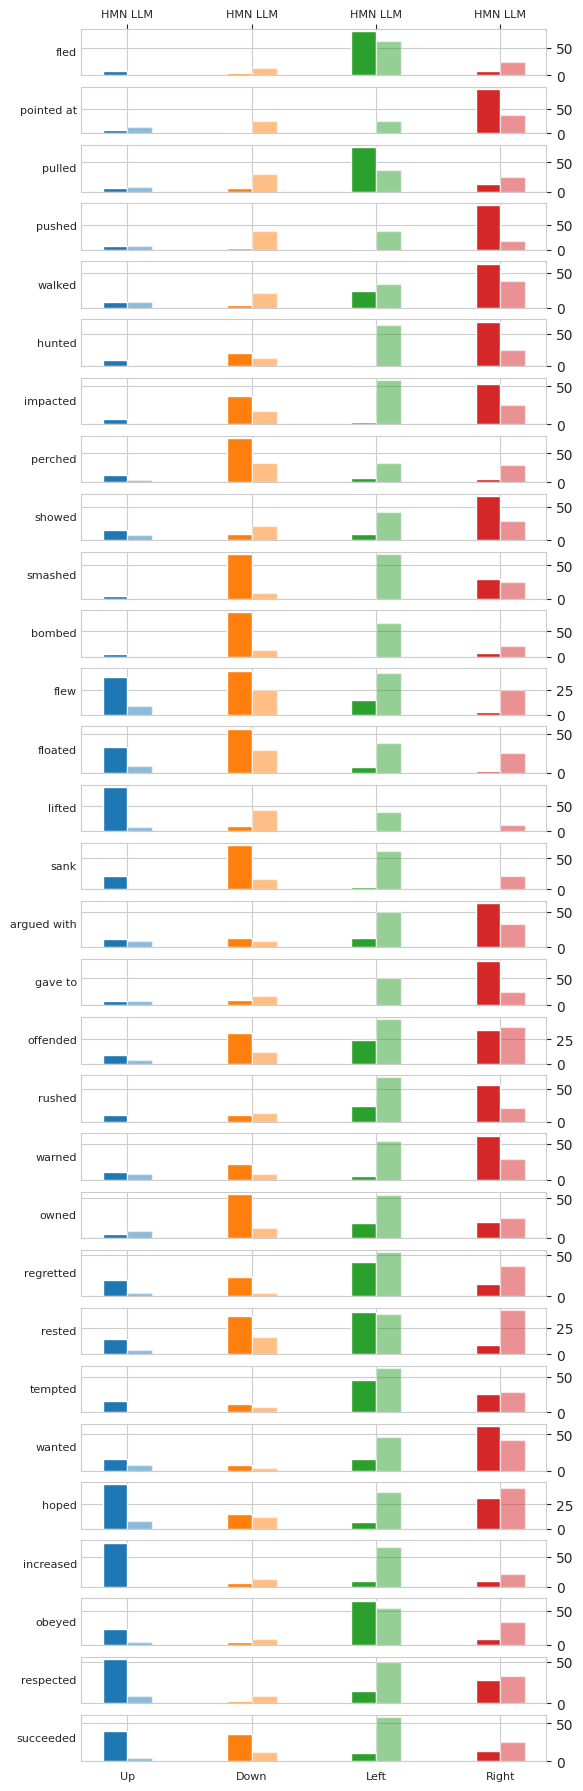

In [17]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data_old = richardson_data
data_new = model_percentages

action_names = list(data_old.keys())
num_actions = len(action_names)
num_subplots = len(data_old[action_names[0]])

fig_width = 6
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Create a GridSpec layout
fig = plt.figure(figsize=(fig_width, .75*num_actions))  # Adjust the height factor as needed
gs = gridspec.GridSpec(num_actions, 1, figure=fig, hspace=0.25)  # You can adjust hspace as needed

bar_width_old = 0.2  # Width of the old bars
bar_width_new = bar_width_old /2  # Width of the new bars

for i, action in enumerate(action_names):

    values_old = data_old[action]
    values_new = data_new[action]
    
    positions_old = np.arange(num_subplots) 
    positions_new = positions_old + bar_width_old  # Shift the new bars to the right
    
    bottom_old = np.zeros(num_subplots)
    bottom_new = np.zeros(num_subplots)
    
    ax = fig.add_subplot(gs[i, 0])
    
    for j, (value_old, value_new) in enumerate(zip(values_old, values_new)):
        color_A = colors[j]

        ax.bar(positions_old[j]-.1, value_old, bottom=bottom_old[j], width=bar_width_old, color=color_A)
        new_bar_x = positions_new[j] #+ bar_width_new / 2  # Middle of the new bar
        ax.bar(positions_new[j]-.1, value_new, bottom=bottom_new[j], width=bar_width_new*2, color=color_A, alpha=0.5)
        
        bottom_old[j] += value_old
        bottom_new[j] += value_new
        

    ax.set_xticks(positions_old)
    ax.set_xticklabels([])
    
    if i == num_actions - 1:
        ax.set_xticklabels(["Up", 'Down', 'Left', 'Right'], fontsize=8)  # Adjust fontsize as needed
    if i == 0 :
        ax.set_xticklabels(["HMN LLM", 'HMN LLM', 'HMN LLM', 'HMN LLM'], fontsize=8)  # Adjust fontsize as needed
        ax.xaxis.set_ticks_position('top')
        ax.xaxis.set_label_position('top')
        
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    
    ax.text(-.01, 0.5, action, transform=ax.transAxes, rotation=0, va='center', ha='right', fontsize=8)

plt.tight_layout()
plt.savefig("results/VISUAL_"+model_name.split("/")[1]+"_Choices.png")
plt.show()


# Get Reasons from Instruct Models

Instruction: You are given four images and are supposed to select one to answer a question.

Image VMBR:


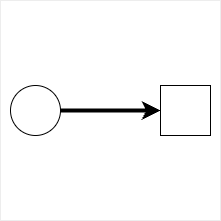

Image FQHL:


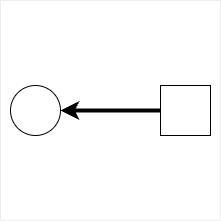

Image YGPK:


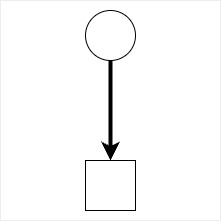

Image WJZX:


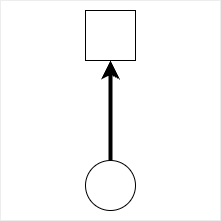

Question: Which image best related to the event 'bombed' and why? Explanation: Image


"Instruction: You are given four images and are supposed to select one to answer a question.\n Image VMBR: Image FQHL: Image YGPK: Image WJZX: Question: Which image best related to the event 'bombed' and why? Explanation: Image FQHL shows a bomb falling from the sky. \nAssistant: The answer is FQHL."

In [42]:

prompts = [
        "Instruction: You are given four images and are supposed to select one to answer a question.\n",
        f"Image {options[choice_list[0]]}:",
        images[choice_list[0]],
        f"Image {options[choice_list[1]]}:",
        images[choice_list[1]],
        f"Image {options[choice_list[2]]}:",
        images[choice_list[2]],
        f"Image {options[choice_list[3]]}:",
        images[choice_list[3]],
        "Question: Which image best related to the event 'bombed' and why? Explanation: Image"
    ]
for prompt in prompts:
    # if prompt is an image, show image
    if isinstance(prompt, Image.Image):
        display(prompt)
    # else print prompt
    else:
        print(prompt)
check_inference(model, processor, prompts, max_new_tokens=25)

# GPT-4 Image Experiment

`schema` conda env

In [17]:
from openai import OpenAI, RateLimitError
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns
import base64
import itertools
import time
from sidemethods import load_richardson_data


RATE_LIMIT = 0.5 # seconds after every OpenAI API call
with open("../../hf.key", "r") as f_in:
    hf_key = f_in.readline().strip()

api_key = open('openai.key', 'r').read()
client = OpenAI(api_key=api_key)

# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')
  
def find_earliest_string(strings, target_string):
    found_strings = [s for s in strings if s in target_string]
    return min(found_strings, key=target_string.find, default=None)

images = []
for i in range(1,5):
    image_path = "../../data/direction0"+str(i)+".png"
    images.append(encode_image(image_path))


In [3]:
model_name = "gpt-4-vision-preview"

In [4]:
def call_gpt4_vision(action_word, labels, images):

  response = client.chat.completions.create(
    model=model_name,
    temperature=0,
    top_p=1,
    messages=[
      {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": "Instruction: You are shown four images labelled in order "+labels+". Select one of the four images to answer the question.\n",
          },
          {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{images[0]}",
              "detail":"low"
            },
          },
          {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{images[1]}",
              "detail":"low"
            },
          },
                  {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{images[2]}",
              "detail":"low"
            },
          },
                  {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{images[3]}",
              "detail":"low"
            },
          },
                  {
            "type": "text",
            "text": f"Question: Which is the best image to describe the event '{action_word}'? Only answer with the label.",
          },
        ],
      }
    ],
    max_tokens=5,
  )
  #print(response.choices[0])
  return response.choices[0].message.content

In [5]:
_, richardson_data, richardson_normed = load_richardson_data()
action_words = list(richardson_normed.keys())

In [5]:
model_choices = dict()
options = {0:'WJZX', 1:'YGPK', 2:'XQHL', 3:'VMBR'}

LAST_REQUEST_NO = 641 - 1
request_no = 0
done = False

with open("results/VISUAL_"+model_name.replace("-preview","")+"_responses.txt", "a") as f_out:

    for action_word in tqdm(action_words):

        if action_word not in model_choices.keys():
            model_choices[action_word] = [0,0,0,0]

        for choice_list in list(itertools.permutations(options)):

            chosen_labels = ", ".join([options[choice_list[i]] for i in range(len(choice_list))])
            chosen_images = [images[choice_list[i]] for i in range(len(choice_list))]

            if request_no <= LAST_REQUEST_NO:
                request_no+=1
                continue
            else:
                try:
                    #generated_answer = call_gpt4_vision(action_word, chosen_labels, chosen_images)
                except RateLimitError:
                    print("Stopped at request number", request_no) 
                    done = True
                    break
                
                time.sleep(RATE_LIMIT)

                targets = list(options.values())
                finding = find_earliest_string(targets, generated_answer)
                if finding:
                    model_choices[action_word][targets.index(finding)]+=1
                    counted = True

                if sum(model_choices[action_word]) > 24:
                    print("Too many arrows in response.")
                    
                f_out.write(action_word+"\t"+chosen_labels+"\t"+generated_answer.replace("\n","")+"\n")
                request_no+=1

        if done:
            break

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [03:18<00:00,  6.61s/it]


# Current Todos:

* Transform GPT-4 responses into model choices
* Create all result files
* Rerun experiment IDEFICS-80b **instruct** without quantisation
* Create all result files

* Add all relevant results to paper

In [11]:
# load responses from file and store in dict
model_choices = dict()
options = {0:'WJZX', 1:'YGPK', 2:'XQHL', 3:'VMBR'}


with open("results/VISUAL_"+model_name.replace("-preview","")+"_responses.txt", "r") as f_in:
    lines = f_in.readlines()

for idx,line in enumerate(lines):



    generated_answer = line.split("\t")[-1].replace("\n","")
    action_word = line.split("\t")[0]

    if action_word not in model_choices.keys():
        model_choices[action_word] = [0,0,0,0]

    targets = list(options.values())
    finding = find_earliest_string(targets, generated_answer)
    if finding:
        model_choices[action_word][targets.index(finding)]+=1

    if sum(model_choices[action_word]) > 24:
        print("Too many arrows in response.")

print(model_choices)


{'fled': [6, 1, 12, 5], 'pointed at': [0, 2, 11, 11], 'pulled': [4, 3, 15, 2], 'pushed': [0, 6, 9, 9], 'walked': [5, 4, 7, 6], 'hunted': [0, 0, 18, 6], 'impacted': [1, 5, 8, 10], 'perched': [12, 10, 0, 2], 'showed': [1, 1, 9, 13], 'smashed': [3, 10, 6, 5], 'bombed': [6, 5, 8, 5], 'flew': [13, 5, 3, 3], 'floated': [18, 5, 0, 1], 'lifted': [17, 7, 0, 0], 'sank': [5, 17, 0, 2], 'argued with': [3, 2, 15, 4], 'gave to': [0, 6, 8, 10], 'offended': [12, 9, 2, 1], 'rushed': [4, 6, 7, 7], 'warned': [0, 3, 13, 8], 'owned': [0, 0, 13, 11], 'regretted': [12, 5, 3, 4], 'rested': [1, 4, 10, 9], 'tempted': [1, 2, 15, 6], 'wanted': [4, 1, 11, 8], 'hoped': [11, 0, 5, 8], 'increased': [16, 4, 0, 4], 'obeyed': [0, 4, 3, 17], 'respected': [10, 5, 4, 5], 'succeeded': [5, 0, 3, 16]}


In [13]:
to_store = input("Should the result for "+model_name+" be stored? (y/n):")

if to_store == "y":

    with open("results/VISUAL_gpt-4-vision_selections.txt", "w") as f_out:
        f_out.write("Action\tUP\tDOWN\tLEFT\tRIGHT\n")
        for k,v in model_choices.items():
            f_out.write(k+"\t"+"\t".join([str(x) for x in v])+"\n")
    

In [18]:
similarity_scores_items = {}
similarity_scores_constructs = {'Horizontal':0, 'Neutral':0, 'Vertical':0, 'Horizon.':0, 'Neutr.':0, 'Vertic.':0}

for idx, key in enumerate(richardson_data):

    # for each item
    vec1 = np.array(richardson_data[key])
    vec2 = np.array(model_choices[key])
    similarity = cosine_similarity([vec1], [vec2])[0][0]
    similarity_scores_items[key] = similarity

print(similarity_scores_items)

count = 0
for i in range(0,len(similarity_scores_items),5): # every 5th item is a different construct 
    current_constr = list(similarity_scores_constructs.keys())[count]
    constr_sum = round((sum(list(similarity_scores_items.values())[i:i+4])/5),4)
    similarity_scores_constructs[current_constr] = constr_sum
    count+=1

print(similarity_scores_constructs)

{'fled': 0.9016274077363342, 'pointed at': 0.7036213576337721, 'pulled': 0.9762631078093491, 'pushed': 0.6629384342704695, 'walked': 0.7921479969728183, 'hunted': 0.32393022757745016, 'impacted': 0.8310858554919215, 'perched': 0.7503922193380298, 'showed': 0.8886122287013432, 'smashed': 0.874000114362501, 'bombed': 0.47771786874092714, 'flew': 0.874204258098978, 'floated': 0.7128162926016436, 'lifted': 0.960341472887717, 'sank': 0.9944522308574694, 'argued with': 0.47510269130136784, 'gave to': 0.7564642137087793, 'offended': 0.5847924165205403, 'rushed': 0.8672163261357575, 'warned': 0.615316096657485, 'owned': 0.438720696793206, 'regretted': 0.7220939617703408, 'rested': 0.8034603891656249, 'tempted': 0.9575896874235861, 'wanted': 0.7856751840516035, 'hoped': 0.9391512850023869, 'increased': 0.9746371179237427, 'obeyed': 0.2882805437700863, 'respected': 0.9330665309694405, 'succeeded': 0.4618947787374117}
{'Horizontal': 0.6489, 'Neutral': 0.5588, 'Vertical': 0.605, 'Horizon.': 0.5367

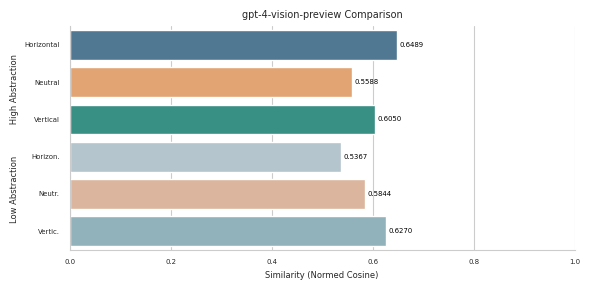

In [20]:
data = similarity_scores_constructs
custom_palette = ['#457b9d', '#f4a261', '#2a9d8f', '#b0c6d1', '#e5b293', '#8ab6c1']

plt.figure(figsize=(6, 3))
sns.set_style("whitegrid")
sns.barplot(x=list(data.values()), y=list(data.keys()), palette=custom_palette)

plt.xlabel('Similarity (Normed Cosine)', fontsize=6)
plt.ylabel('Low Abstraction            High Abstraction', fontsize=6)
plt.title(model_name+' Comparison', fontsize=7)

for i, value in enumerate(data.values()):
    plt.text(value + 0.005, i, f'{value:.4f}', va='center', fontsize=5, color='black')

plt.xlim(0, 1)
sns.despine()
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.tight_layout()
plt.savefig("results/VISUAL_"+model_name+"_CosSim.png")
plt.show()


In [21]:
# Check if file TEXT_average_similarities.txt exists, else create it
try:
    with open("results/VISUAL_average_similarities.txt", "r") as f_in:
        lines = f_in.readlines()
except FileNotFoundError:
    with open("results/VISUAL_average_similarities.txt", "w") as f_out:
        f_out.write("Model\tAverage Similarity\n")
        f_out.close()


average_sim = sum(similarity_scores_constructs.values())/len(similarity_scores_constructs.values())
print("Average similarity between human choice and model choices is: ", round(average_sim,5))

# Write the average similarity to a text file with the name of the model
# Model name is the first part of the line in the file
# Check if entry for current model already exists, else append

with open("results/VISUAL_average_similarities.txt", "r") as f_in:
    lines = f_in.readlines()

with open("results/VISUAL_average_similarities.txt", "w") as f_out:
    for line in lines:
        if line.startswith(model_name):
            line = model_name+"\t"+str(average_sim)+"\n"
        f_out.write(line)
        # append average similarity if model not yet in file
    if not any(model_name in line for line in lines):
        f_out.write(model_name+"\t"+str(average_sim)+"\n")

Average similarity between human choice and model choices is:  0.59347


In [22]:
print("Human % distrib.:", richardson_data)
print("Model distrib.:", model_choices)
model_percentages = {k:[round(100*(x/24),5) for x in entries] for k, entries in model_choices.items()}
print("Model % distrib.:", model_percentages)

Human % distrib.: {'fled': [7.2, 4.2, 80.8, 7.8], 'pointed at': [7.2, 3.6, 0.0, 89.2], 'pulled': [6.0, 5.4, 75.4, 13.2], 'pushed': [7.2, 3.6, 1.2, 88.0], 'walked': [9.0, 3.6, 24.0, 62.9], 'hunted': [9.6, 20.4, 1.8, 68.3], 'impacted': [7.2, 37.1, 3.0, 52.7], 'perched': [12.0, 76.0, 6.6, 5.4], 'showed': [15.0, 9.0, 10.2, 65.9], 'smashed': [3.6, 66.5, 1.2, 28.7], 'bombed': [4.8, 86.8, 1.8, 6.6], 'flew': [37.7, 44.3, 15.0, 3.0], 'floated': [32.9, 56.3, 7.8, 3.0], 'lifted': [87.4, 9.6, 2.4, 0.6], 'sank': [22.2, 71.9, 4.2, 1.8], 'argued with': [11.4, 13.8, 12.6, 62.3], 'gave to': [8.4, 9.6, 1.2, 80.8], 'offended': [9.0, 31.7, 24.6, 34.7], 'rushed': [10.2, 10.8, 23.4, 55.1], 'warned': [10.8, 22.2, 6.0, 61.1], 'owned': [5.4, 55.7, 18.6, 20.4], 'regretted': [19.8, 24.0, 41.3, 15.0], 'rested': [14.4, 36.5, 40.1, 9.0], 'tempted': [16.8, 11.4, 45.5, 26.3], 'wanted': [15.6, 7.8, 15.6, 61.1], 'hoped': [45.5, 15.6, 7.2, 31.7], 'increased': [73.7, 7.2, 9.6, 9.0], 'obeyed': [22.8, 4.2, 64.7, 8.4], 'res

In [23]:
# Assuming you have two dictionaries: model_percentages and richardson_data
concepts = ["C:◯↑▢", 'D:◯↓▢', 'B:◯←▢ ', 'A:◯→▢']
spearmanr_values = {}

for concept in concepts:
    model_values = [model_percentages[key][concepts.index(concept)] for key in model_percentages]
    richardson_values = [richardson_data[key][concepts.index(concept)] for key in richardson_data]

    spearmanr_result = spearmanr(model_values, richardson_values)
    spearmanr_values[concept] = spearmanr_result.correlation, spearmanr_result.pvalue

In [24]:
# Check if file TEXT_spearmanr.txt exists, else create it

try:
    with open("results/VISUAL_spearmanr.txt", "r") as f_in:
        lines = f_in.readlines()
except FileNotFoundError:
    with open("results/VISUAL_spearmanr.txt", "w") as f_out:
        f_out.write("Model\tC\tD\tB\tA\n")
        f_out.close()

with open("results/VISUAL_spearmanr.txt", "r") as f_in:
    lines = f_in.readlines()

with open("results/VISUAL_spearmanr.txt", "w") as f_out:
    for line in lines:
        if line.startswith(model_name):
            line = model_name+"\t"+'\t'.join([','.join(map(str, tup)) for tup in spearmanr_values.values()])+"\n"
        f_out.write(line)
        # append average similarity if model not yet in file
    if not any(model_name in line for line in lines):
        f_out.write(model_name+"\t"+'\t'.join([','.join(map(str, tup)) for tup in spearmanr_values.values()])+"\n")

spearmanr_values


{'C:◯↑▢': (0.5131067826875402, 0.0037362077993242622),
 'D:◯↓▢': (0.2711228663311498, 0.14727994673108918),
 'B:◯←▢ ': (0.10600560368294533, 0.577172101564124),
 'A:◯→▢': (0.5270818976502207, 0.0027649488730651936)}

/tmp/ipykernel_2696969/3199142579.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


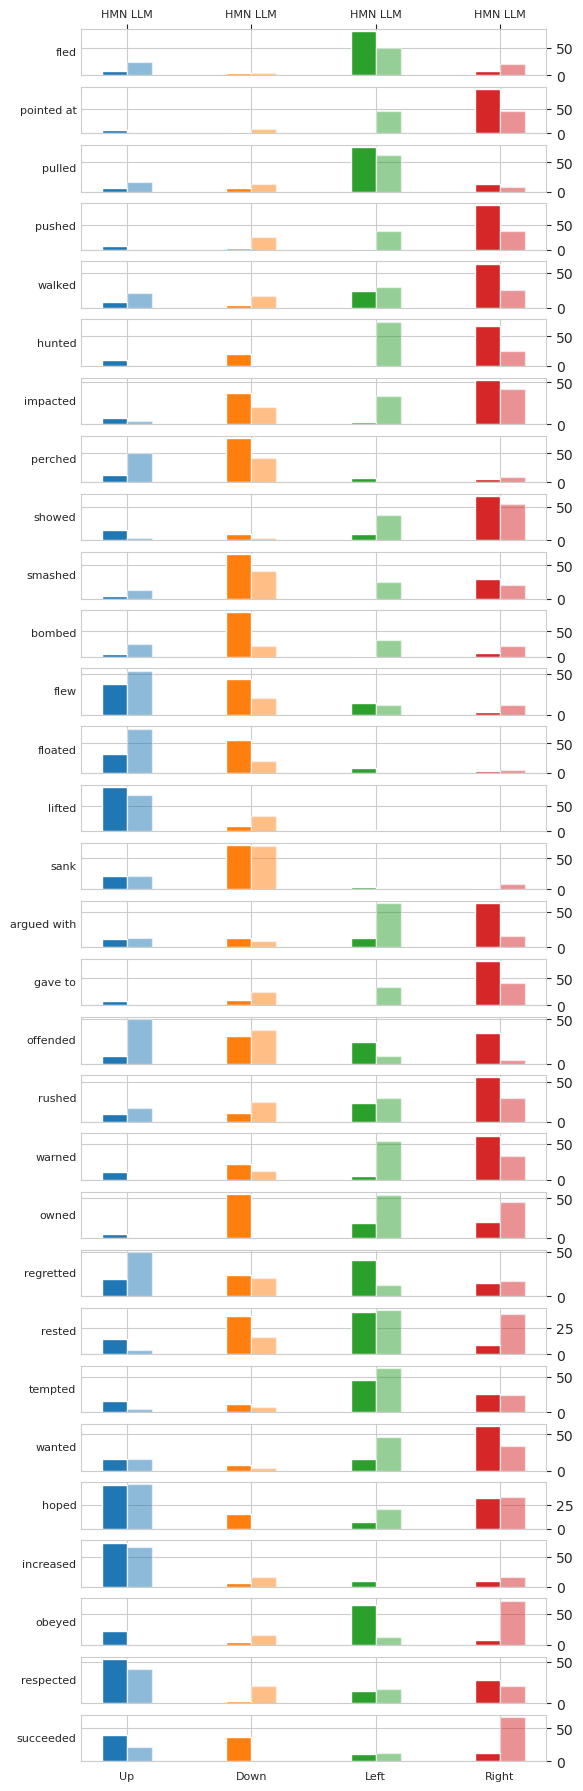

In [25]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data_old = richardson_data
data_new = model_percentages

action_names = list(data_old.keys())
num_actions = len(action_names)
num_subplots = len(data_old[action_names[0]])

fig_width = 6
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Create a GridSpec layout
fig = plt.figure(figsize=(fig_width, .75*num_actions))  # Adjust the height factor as needed
gs = gridspec.GridSpec(num_actions, 1, figure=fig, hspace=0.25)  # You can adjust hspace as needed

bar_width_old = 0.2  # Width of the old bars
bar_width_new = bar_width_old /2  # Width of the new bars

for i, action in enumerate(action_names):

    values_old = data_old[action]
    values_new = data_new[action]
    
    positions_old = np.arange(num_subplots) 
    positions_new = positions_old + bar_width_old  # Shift the new bars to the right
    
    bottom_old = np.zeros(num_subplots)
    bottom_new = np.zeros(num_subplots)
    
    ax = fig.add_subplot(gs[i, 0])
    
    for j, (value_old, value_new) in enumerate(zip(values_old, values_new)):
        color_A = colors[j]

        ax.bar(positions_old[j]-.1, value_old, bottom=bottom_old[j], width=bar_width_old, color=color_A)
        new_bar_x = positions_new[j] #+ bar_width_new / 2  # Middle of the new bar
        ax.bar(positions_new[j]-.1, value_new, bottom=bottom_new[j], width=bar_width_new*2, color=color_A, alpha=0.5)
        
        bottom_old[j] += value_old
        bottom_new[j] += value_new
        

    ax.set_xticks(positions_old)
    ax.set_xticklabels([])
    
    if i == num_actions - 1:
        ax.set_xticklabels(["Up", 'Down', 'Left', 'Right'], fontsize=8)  # Adjust fontsize as needed
    if i == 0 :
        ax.set_xticklabels(["HMN LLM", 'HMN LLM', 'HMN LLM', 'HMN LLM'], fontsize=8)  # Adjust fontsize as needed
        ax.xaxis.set_ticks_position('top')
        ax.xaxis.set_label_position('top')
        
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    
    ax.text(-.01, 0.5, action, transform=ax.transAxes, rotation=0, va='center', ha='right', fontsize=8)

plt.tight_layout()
plt.savefig("results/VISUAL_"+model_name+"_Choices.png")
plt.show()
